<a href="https://colab.research.google.com/github/rallyfranky/my-first-repo/blob/main/%E3%83%99%E3%82%A4%E3%82%BA%E3%81%AE%E8%A8%93%E7%B7%B4%EF%BC%A0%E9%9A%8E%E5%B1%A4%E3%83%99%E3%82%A4%E3%82%BA%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://gist.github.com/trycycle/e0d7b2d5792bfda3b933340c0a075fc3#file-homerun-ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpyro
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
import matplotlib.pyplot as plt

In [13]:
import arviz as az

In [4]:
batting_df = pd.read_csv('/content/drive/MyDrive/train/Batting.csv')
player_df = pd.read_csv('/content/drive/MyDrive/train/People.csv')

In [5]:
df = pd.merge(
    player_df, batting_df, on='playerID'
).assign(
    age = lambda _df: _df['yearID'] - _df['birthYear'],
    PA = lambda _df: _df['AB'] + _df['BB'] + _df['HBP'] + _df['SH'] + _df['SF']
).assign(
    # transformメソッドは，groupbyされる前のレコードにgroupby上の集約演算結果を付け足す
    # （applyメソッドは，単純にgroupby上での集約演算を返す）
    # 詳しくは https://qiita.com/greenteabiscuit/items/132e0f9b1479926e07e0
    career_PA = lambda _df: _df.groupby('playerID')['PA'].transform('sum')
)

In [7]:
data = df.dropna(
    subset=['AB']
)[
    df.career_PA >= 10000
][
    ['playerID', 'yearID', 'age', 'AB', 'HR']
].assign(
    # ageがfloat型になっているので，int型に変換しておく
    age = lambda df: df.age.astype(np.int32)
).assign(
    # 最小年齢がゼロになるように修正した年齢情報を用意する
    modified_age = lambda df: df.age - min(df.age)
)

In [8]:
min_age = min(data.age)
max_age = max(data.age)

print("生涯打席数が10000以上の選手の数 = {}".format(data.shape[0]))
print("最小年齢 = {}".format(min_age))
print("最高年齢 = {}".format(max_age))

生涯打席数が10000以上の選手の数 = 1339
最小年齢 = 18
最高年齢 = 46


In [9]:
def plot_basic_HRR():
    data['HRR'] = data['HR'] / data['AB']
    
    data.groupby('age').agg({'HRR': np.median}).reset_index().pipe(
        lambda df: plt.plot(df['age'], df['HRR'], "o-", color="green", alpha=0.3)
    )

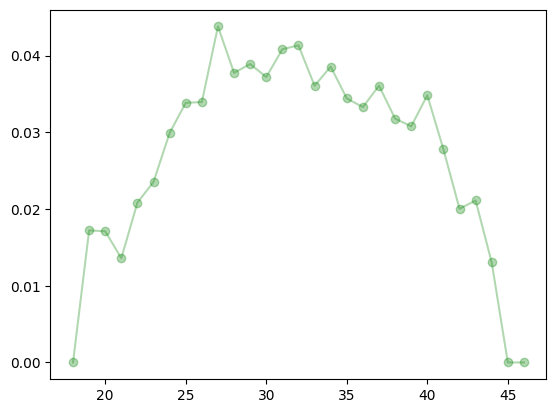

In [10]:
plot_basic_HRR()

In [11]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

In [12]:
def plot_r_age_posterior(_samples):
    age_range = [i for i in range(18, 46)]

    # 中央値のプロット
    r_age_median = np.median(_samples['r_age'], axis=0)    
    plt.plot(age_range, r_age_median, "o-", color="blue")
    
    # HPD(Highest Posterior Density) intervalの表示
    az.plot_hdi(age_range, _samples['r_age'], color="blue",
                fill_kwargs={'alpha': 0.1})

In [14]:
def plot_HRR_posterior(_samples):
    age_range = [i for i in range(18, 45)]

    # 中央値のプロット
    HRR_age_median = np.median(_samples['HRR_age'], axis=0)    
    plt.plot(age_range, HRR_age_median, "o-", color="blue")
    
    # HPD(Highest Posterior Density) intervalの表示
    az.plot_hpd(age_range, _samples['HRR_age'], color="blue",
                fill_kwargs={'alpha': 0.1})

In [15]:
def model_1(ABs, HRs=None, ages=None):
    player_num = ABs.shape[0]
    
    beta = numpyro.sample("beta", dist.Normal(0, 1))#HRR=beta
    sd_age = numpyro.sample("sd_age", dist.HalfCauchy(1))
    with numpyro.plate("age_num", max(ages)):
        r_age = numpyro.sample("r_age", dist.Normal(0, sd_age))
        numpyro.deterministic('HRR_age', sigmoid(beta + r_age)) # 年齢毎の本塁打率をtraceするために保存しておく        

    # logit=xとすると，logit(p) = x 
    HRRs = beta + r_age[ages]
    numpyro.sample("obs", dist.Binomial(ABs, logits=HRRs), obs=HRs)

In [18]:
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

num_warmup, num_samples = 1000, 3000
kernel = numpyro.infer.NUTS(model_1)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key, data.AB.values, data.HR.values, data.modified_age.values)

samples = mcmc.get_samples()

# 推定パラメータの基本統計量
# mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 488.10it/s, 15 steps of size 1.24e-01. acc. prob=0.94]  


/usr/local/lib/python3.9/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (58), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'HRR_age\n0'}>,
        <Axes: title={'center': 'HRR_age\n0'}>],
       [<Axes: title={'center': 'HRR_age\n1'}>,
        <Axes: title={'center': 'HRR_age\n1'}>],
       [<Axes: title={'center': 'HRR_age\n2'}>,
        <Axes: title={'center': 'HRR_age\n2'}>],
       [<Axes: title={'center': 'HRR_age\n3'}>,
        <Axes: title={'center': 'HRR_age\n3'}>],
       [<Axes: title={'center': 'HRR_age\n4'}>,
        <Axes: title={'center': 'HRR_age\n4'}>],
       [<Axes: title={'center': 'HRR_age\n5'}>,
        <Axes: title={'center': 'HRR_age\n5'}>],
       [<Axes: title={'center': 'HRR_age\n6'}>,
        <Axes: title={'center': 'HRR_age\n6'}>],
       [<Axes: title={'center': 'HRR_age\n7'}>,
        <Axes: title={'center': 'HRR_age\n7'}>],
       [<Axes: title={'center': 'HRR_age\n8'}>,
        <Axes: title={'center': 'HRR_age\n8'}>],
       [<Axes: title={'center': 'HRR_age\n9'}>,
        <Axes: title={'center': 'HRR_age\n9'}>],
       [<Axes: title={'center'

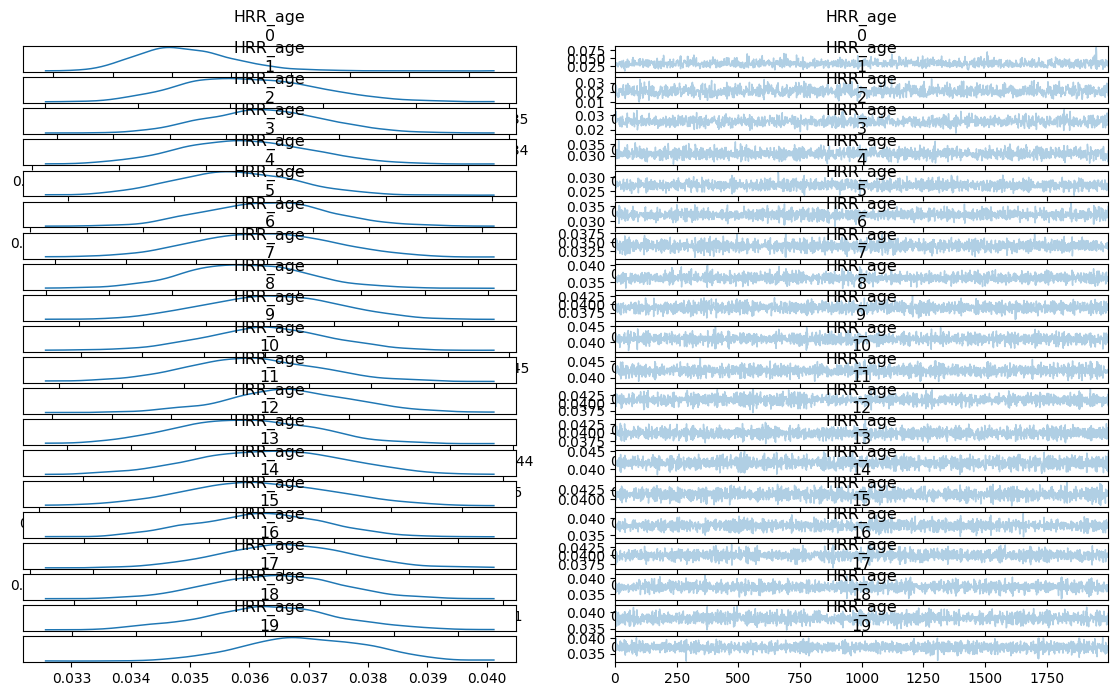

In [20]:
az.plot_trace(mcmc,compact=False,figsize=(14,8))

In [23]:
mcmc_samples = mcmc.get_samples()

In [24]:
mcmc_samples

{'HRR_age': Array([[0.03259491, 0.0238497 , 0.02729067, ..., 0.02992728, 0.02113771,
         0.01956217],
        [0.03485277, 0.02382596, 0.02440901, ..., 0.02827284, 0.02122852,
         0.01787849],
        [0.02725919, 0.02778487, 0.02449666, ..., 0.02698174, 0.01863143,
         0.01996308],
        ...,
        [0.03609848, 0.02318718, 0.02760285, ..., 0.02429058, 0.01651096,
         0.02136468],
        [0.02776289, 0.01888284, 0.02554892, ..., 0.02790396, 0.01249824,
         0.02342824],
        [0.02315644, 0.01677473, 0.02581984, ..., 0.02634363, 0.01708537,
         0.01227506]], dtype=float32),
 'beta': Array([-3.3210518, -3.3438768, -3.3443756, ..., -3.4121327, -3.405048 ,
        -3.3987901], dtype=float32),
 'r_age': Array([[-0.06940936, -0.39079314, -0.25248867, ..., -0.15754876,
         -0.5142807 , -0.59334975],
        [ 0.02272861, -0.36898836, -0.34421438, ..., -0.19329669,
         -0.4870759 , -0.66224   ],
        [-0.23035127, -0.21071012, -0.34004107, ...,

/usr/local/lib/python3.9/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<Axes: >

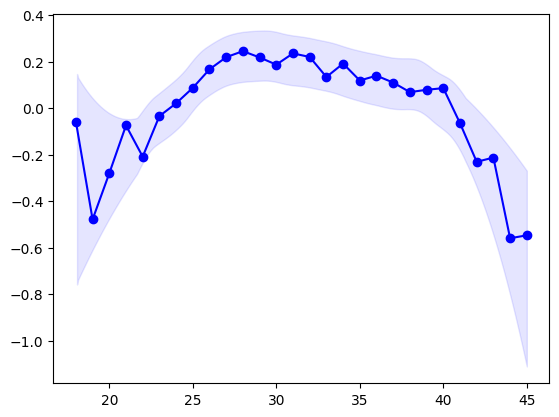

In [29]:
age_range = [i for i in range(18, 46)]

# 中央値のプロット
r_age_median = np.median(mcmc_samples['r_age'], axis=0)    
plt.plot(age_range, r_age_median, "o-", color="blue")
    
# HPD(Highest Posterior Density) intervalの表示
az.plot_hdi(age_range, mcmc_samples['r_age'], color="blue",fill_kwargs={'alpha': 0.1})

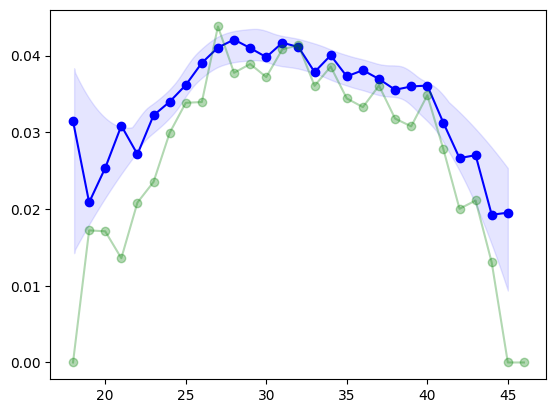

In [36]:
# 中央値のプロット
HRR_age_median = np.median(mcmc_samples['HRR_age'], axis=0)    
plt.plot(age_range, HRR_age_median, "o-", color="blue")
    
# HPD(Highest Posterior Density) intervalの表示
az.plot_hdi(age_range, mcmc_samples['HRR_age'], color="blue",fill_kwargs={'alpha': 0.1})
plot_basic_HRR()